In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [76]:
data_path = '/Users/stephenthomas/Google Drive/Research/2017/LabNotes/Data/Jun10/units_converted'

# Comparing k2/k1 between experiment, theory and simulation

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


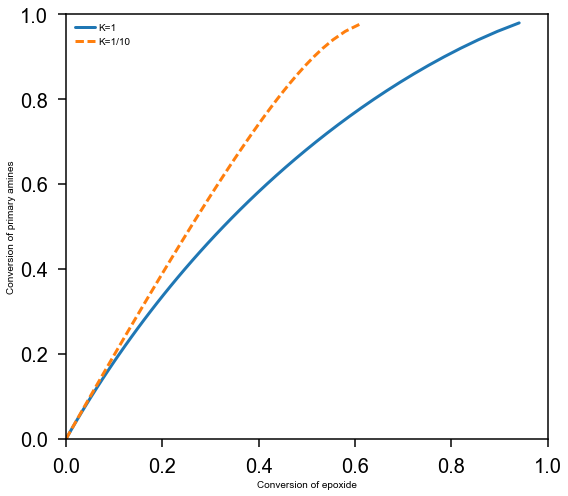

In [77]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

def pa(pbs,rb):
    pas = []
    for pb in pbs:
        pas.append(rb* (2*pb - (pb - 1)* math.log(1 - pb)) )
    return pas
def pa_k_not_1(pbs,rb,k):
    pas = []
    for pb in pbs:
        pas.append((rb* ((1 - pb)**k + pb* (2*k - 1) - 1))/(k - 1))
    return pas

pbs = np.linspace(0,1,endpoint=False)
plt.figure(figsize=(8,7))
plt.axis((0.0,1.0,0.0,1.0))
plt.xlabel('Conversion of epoxide')
plt.ylabel('Conversion of primary amines')
pas = pa(pbs,rb=1/2.)
plt.plot(pas,pbs,label='K=1')
pas = pa_k_not_1(pbs,rb=1/2.,k=1/10)
plt.plot(pas,pbs,linestyle='--',label='K=1/10')
plt.legend()

dacf15b7ac4376fe389f511c4cc7cafd 0.4
10635a3091eeafcbb728360331894078 0.5
ca284264cf0205bf7d76af0a1a756e9a 0.6
98c9fb056699858b04350c88def40ad1 0.7
be5ec8c95f34e1cbdc8e99c2e2d23044 0.8
8d509bb67b43a1d3968d57155d68b559 0.9
3a535908dc785d316d860d912643059a 1.0
b39dd931bbda7b1b098a25e2a86808b1 1.1
d9f27822eb9cda34e96762859617f8f5 1.2
19cfeb9c447431f77d0e5224f940fba4 1.3
[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3] [41.2575, 54.787500000000001, 66.457499999999996, 74.382499999999993, 80.189999999999998, 84.575000000000003, 87.22999999999999, 89.472499999999997, 90.702500000000001, 91.674999999999997]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


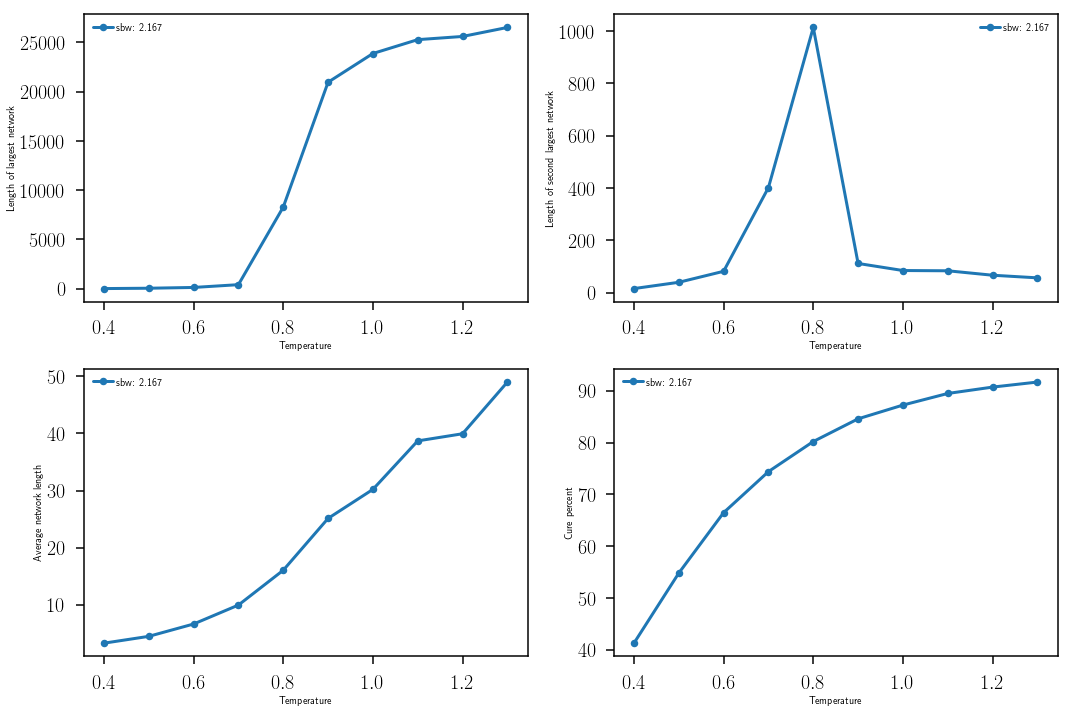

In [200]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)


sbws = [2.167]
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
#fig, ax1 = plt.subplots(figsize=(15,10))
kTs=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
    
for sbw in sbws:
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []
    cure_percent = []
    plt_kTs = []    
    for kT in kTs:
        jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
        for job in jobs:
            #print(job)
            job_status = get_status(job)
            #print(job.sp.temp_prof[-1][1])
            if job.sp.temp_prof[-1][1] ==kT:
                if job_status == 'job-computed':
                    #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
                    print(job,job.sp.temp_prof[-1][1])
                    plt_kTs.append(job.sp.temp_prof[-1][1])
                    f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
                    t = gsd.hoomd.HOOMDTrajectory(f)
                    n_frames = len(t)
                    #print('total frames ',n_frames)
                    connected_components = []
                    last_frame = n_frames-1
                    snapshot = t[last_frame]
                    sim_box = snapshot.configuration.box
                    fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                    bonds = snapshot.bonds.group
                    G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                    G.graph
                    bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                    ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                    ab_bonds = [bonds[i] for i in ab_indices]
                    for bond in ab_bonds:
                        G.add_edge(bond[0],bond[1])
                    n_connected = nx.number_connected_components(G)
                    largest_cc = max(nx.connected_components(G), key=len)
                    connected_components.append(n_connected)
                    largest_networks.append(len(largest_cc))
                    sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
                    second_largest_networks.append(sorted_cc[1])
                    average_network_lens.append(np.mean(sorted_cc))

                    curing_data = np.genfromtxt(job.fn('bond_rank_hist.log'))
                    cure_percent.append(curing_data[-1,1])
                else:
                    print(job)
    ax1.plot(plt_kTs, largest_networks,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    ax2.plot(plt_kTs, second_largest_networks,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    ax3.plot(plt_kTs, average_network_lens,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    ax4.plot(plt_kTs, cure_percent,linestyle='-',marker='o',label='sbw: {}'.format(sbw))
    print(plt_kTs,cure_percent)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Length of largest network')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Length of second largest network')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Average network length')
ax4.set_xlabel('Temperature')
ax4.set_ylabel('Cure percent')
fig.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig('inside_exponent.png'.format(sbw,kT))
plt.show()

[1, 100, 1000, 10000, 100000]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[0 0 0 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0  0 19 10  4  0] 2 1000
[2390 5311 3152 1880 1265  970] 1 100


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


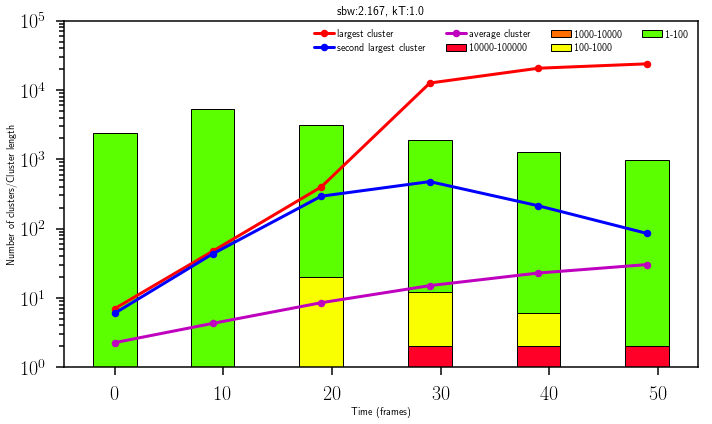

[0 0 0 0 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0  0  4 34 12  2] 2 1000
[2421 5669 3790 2391 1595 1161] 1 100


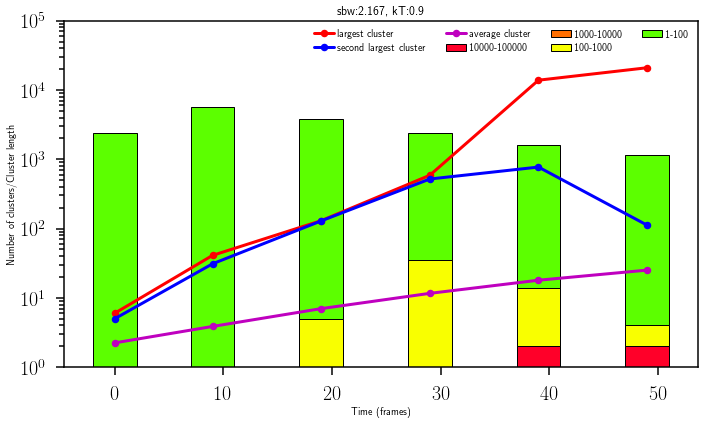

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 2] 3 10000
[ 0  0  0 12 41 20] 2 1000
[2426 6020 4681 3340 2356 1786] 1 100


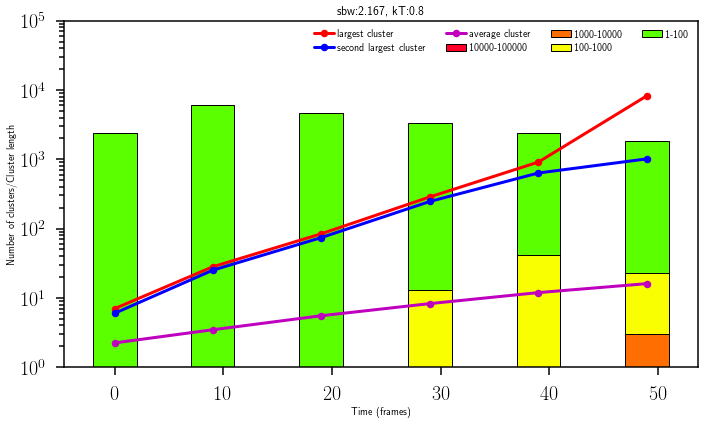

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2410 5799 6685 6674 6310 5908] 1 100


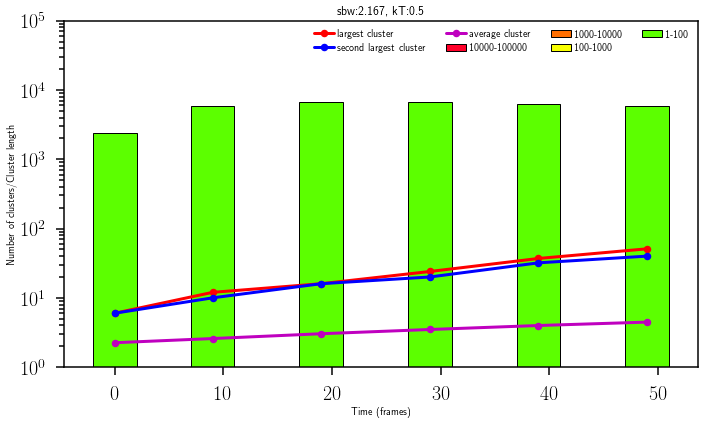

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0  2 13  0  0  0] 2 1000
[2434 4238 1808 1013  719  601] 1 100


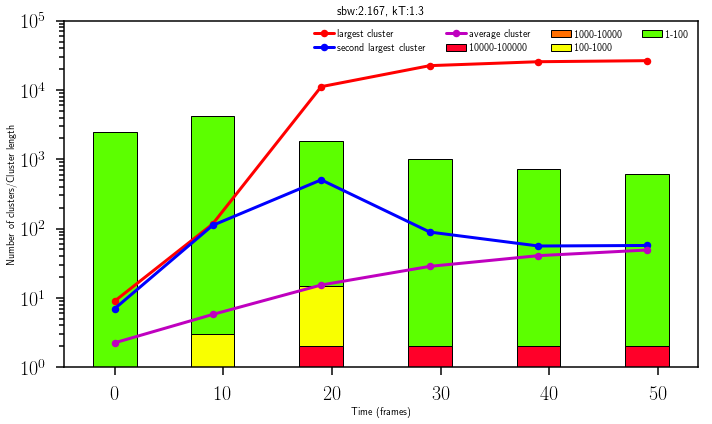

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 0] 2 1000
[2402 4926 6261 6816 7039 7081] 1 100


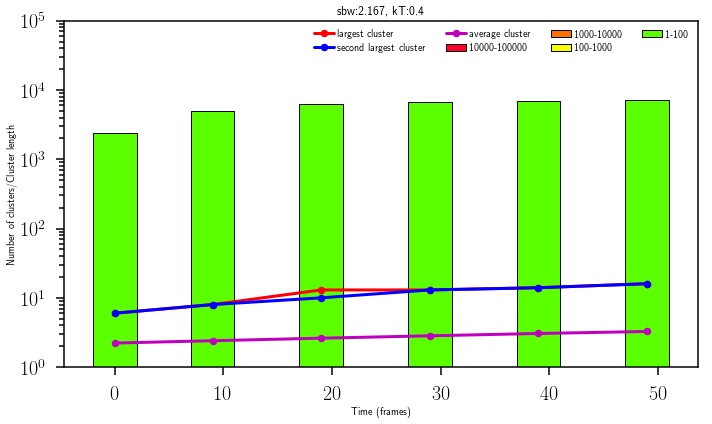

[0 0 0 1 1 1] 4 100000
[0 0 2 0 0 0] 3 10000
[ 0  0 37  6  1  0] 2 1000
[2431 4599 2194 1260  891  737] 1 100


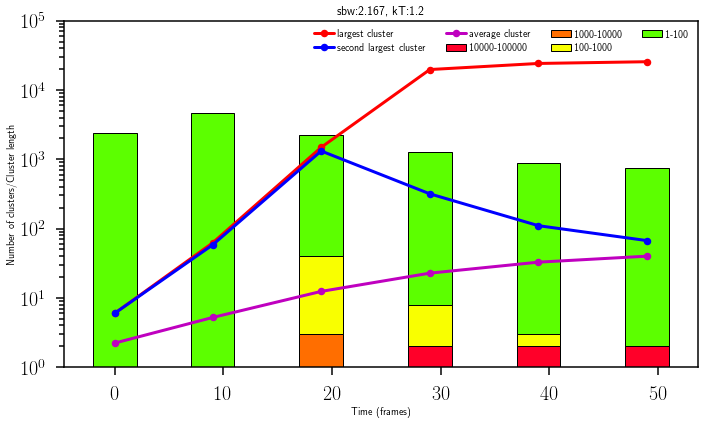

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0  0  0  0 13 33] 2 1000
[2418 6275 5681 4592 3599 2850] 1 100


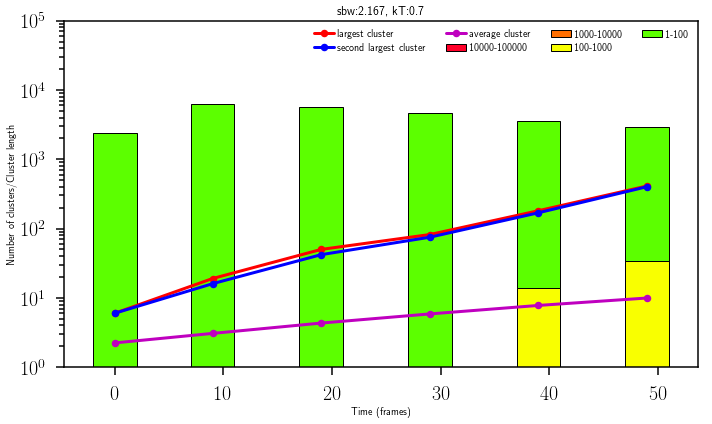

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 0 0 0 1] 2 1000
[2437 6195 6335 5651 4887 4227] 1 100


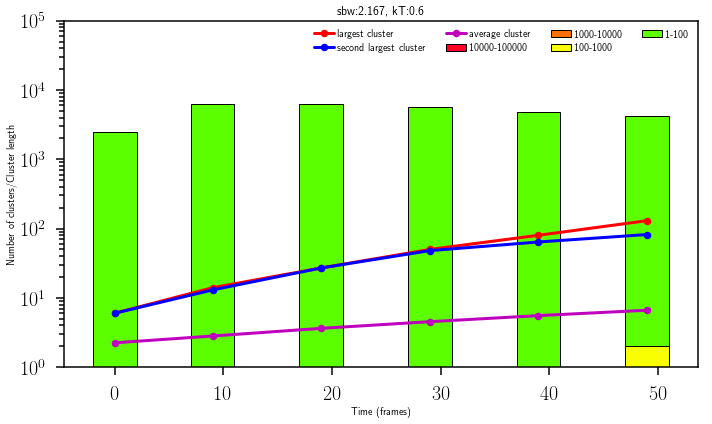

[0 0 0 1 1 1] 4 100000
[0 0 0 1 0 0] 3 10000
[ 0  0 31 10  2  0] 2 1000
[2427 4906 2494 1354  929  759] 1 100


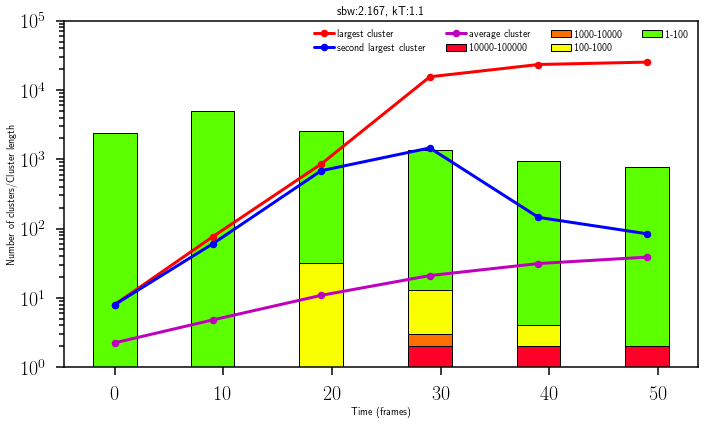

In [201]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
import math
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

sbws = [2.167]
plt.figure(figsize=(15,10))
#bins = [1,5,10,50,100,1000,10000,20000,25000,27500,30000]#np.logspace(0.2,4.5,num=15)
bins = [1,100,1000,10000,100000]
#bins = np.logspace(0.,4.5,num=15)
print(bins)
#bins = np.linspace(0,40000,num=15)
bin_mids = []

NUM_COLORS = 10

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
#plt.color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
E_a = 1.0

for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []

    jobs = project.find_jobs({'activation_energy':E_a, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job_status)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':# and job.sp.temp_prof[-1][1]==1:
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            #print(job)
            kT = job.sp.temp_prof[-1][1]
            kTs.append(kT)
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            #print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            time_steps = np.linspace(0,last_frame,6,endpoint=True,dtype=int)
            cluster_distributions = []
            largest_networks = []
            second_largest_networks = []
            average_network_lens = []
            for ts in time_steps:
                #print((ts))
                snapshot = t[int(ts)]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=False)]
                hist,bin_edges = np.histogram(sorted_cc,bins=bins)
                cluster_distributions.append(hist)
                largest_networks.append(sorted_cc[-1])
                second_largest_networks.append(sorted_cc[-2])
                average_network_lens.append(np.mean(sorted_cc))
            
            distribs = np.array(cluster_distributions)
            fig = plt.figure(figsize=(10,6))
            width=4
            ax = fig.add_subplot(111)
            ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
            bin_mids=[]
            for i,bin_edge in enumerate(bin_edges):
                if i>0:
                    bin_mids.append((bin_edge+bins[i-1])/2.)
            #print('bin_edges\n',bin_edges)
            #print('distribs\n',distribs)
            for i,bin_edge in reversed(list(enumerate(bin_edges))):
                #print(distribs[:,i],i)
                if i>0:
                    label = '{}-{}'.format(int(bin_edges[i-1]),int(bin_edges[i]))
                    #print('label is ',label)
                    dist = distribs[:,i-1]

                    print(dist,i,bin_edge)
                    if i == len(bin_edges)-1:
                        slice_sum = np.ones_like(dist)
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
                    else:
                        #if i == 1:
                        #    print(dist)
                        
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
            plt.plot(time_steps, largest_networks,color='r',linestyle='-',marker='o',label='largest cluster')
            plt.plot(time_steps, second_largest_networks,color='b',linestyle='-',marker='o',label='second largest cluster')
            plt.plot(time_steps, average_network_lens,color='m',linestyle='-',marker='o',label='average cluster')
                #print(slice_sum)
            plt.legend(ncol=4)
            plt.xlabel('Time (frames)')
            plt.ylabel('Number of clusters/Cluster length')
            
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2,1.0,100000.0))
            #plt.xscale('log')
            plt.yscale('log')
            k2_k1 = math.exp(E_a*(sbw-1)/kT)
            plt.title('sbw:{}, kT:{}'.format(sbw,kT))
            plt.savefig('sbw_inside_e_{}_kT_{}.png'.format(sbw,kT))
            plt.show()

dacf15b7ac4376fe389f511c4cc7cafd
(50, 7)
be5ec8c95f34e1cbdc8e99c2e2d23044
(50, 7)
19cfeb9c447431f77d0e5224f940fba4
(50, 7)
1.3 [  0.      11.77    18.945   25.5025  31.805   37.2575  42.3925  46.9325
  50.8825  54.6775  57.8525  60.9     63.505   65.9875  68.22    70.305
  72.1725  73.69    75.1175  76.3875  77.59    78.71    79.6725  80.6325
  81.415   82.2725  83.045   83.7125  84.41    84.9375  85.5325  86.035
  86.485   87.015   87.465   87.87    88.2325  88.5575  88.8825  89.17
  89.49    89.8025  90.095   90.315   90.56    90.8125  91.0725  91.3025
  91.5025  91.675 ]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


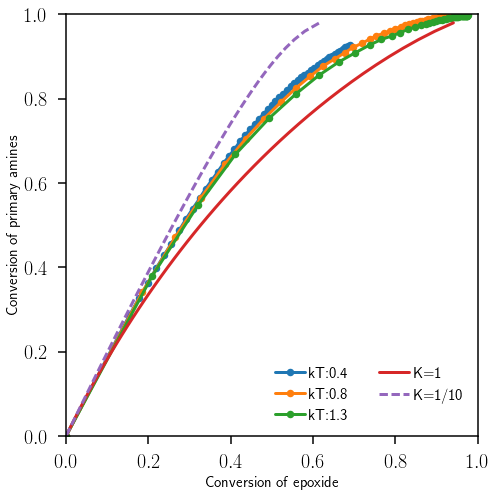

In [482]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)


sbws = [2.167]
fig = plt.figure(figsize=(7,7))
pltId = 221
#fig, ax1 = plt.subplots(figsize=(15,10))
kTs=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
kTs=[0.4, 0.8, 1.3]
    
for sbw in sbws:
    for kT in kTs:
        jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
        for job in jobs:
            #print(job)
            job_status = get_status(job)
            #print(job.sp.temp_prof[-1][1])
            if job.sp.temp_prof[-1][1] ==kT:
                if job_status == 'job-computed':
                    print(job)
                    curing_data = np.genfromtxt(job.fn('bond_rank_hist.log'))
                    #ax1 = fig.add_subplot(pltId)
                    time_steps = curing_data[:,0]/0.01
                    cure_percent = curing_data[:,1]
                    epoxy_conversion = (100.0-curing_data[:,6])/100.
                    primary_amine_conversion = (curing_data[:,2]+curing_data[:,3]+curing_data[:,4]+curing_data[:,5])/100.
                    print(curing_data.shape)
                    #ax1.plot(time_steps, cure_percent,linestyle='-',marker='o',label='Cure percent')
                    #ax1.plot(time_steps, epoxy_conversion,linestyle='-',marker='o',label='Conversion of epoxide')
                    #ax1.plot(time_steps, primary_amine_conversion,linestyle='-',marker='o',label='Conversion of primary amine')
                    plt.plot(epoxy_conversion, primary_amine_conversion,linestyle='-',marker='o',label='kT:{}'.format(kT))
                    
                    
                    pltId+=1
                else:
                    print(job)
    
    print(kT,cure_percent)

pbs = np.linspace(0,1,endpoint=False)
pas = pa(pbs,rb=1/2.)
plt.plot(pas,pbs,label='K=1')
pas = pa_k_not_1(pbs,rb=1/2.,k=1/10)
plt.plot(pas,pbs,linestyle='--',label='K=1/10')                    
fig.tight_layout()
plt.legend(ncol=2,fontsize=15)
#plt.savefig('inside_exponent.png'.format(sbw,kT))
plt.xlabel('Conversion of epoxide',fontsize=15)
plt.ylabel('Conversion of primary amines',fontsize=15)
plt.axis((0.0,1.0,0.0,1.0))
                    
plt.show()

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


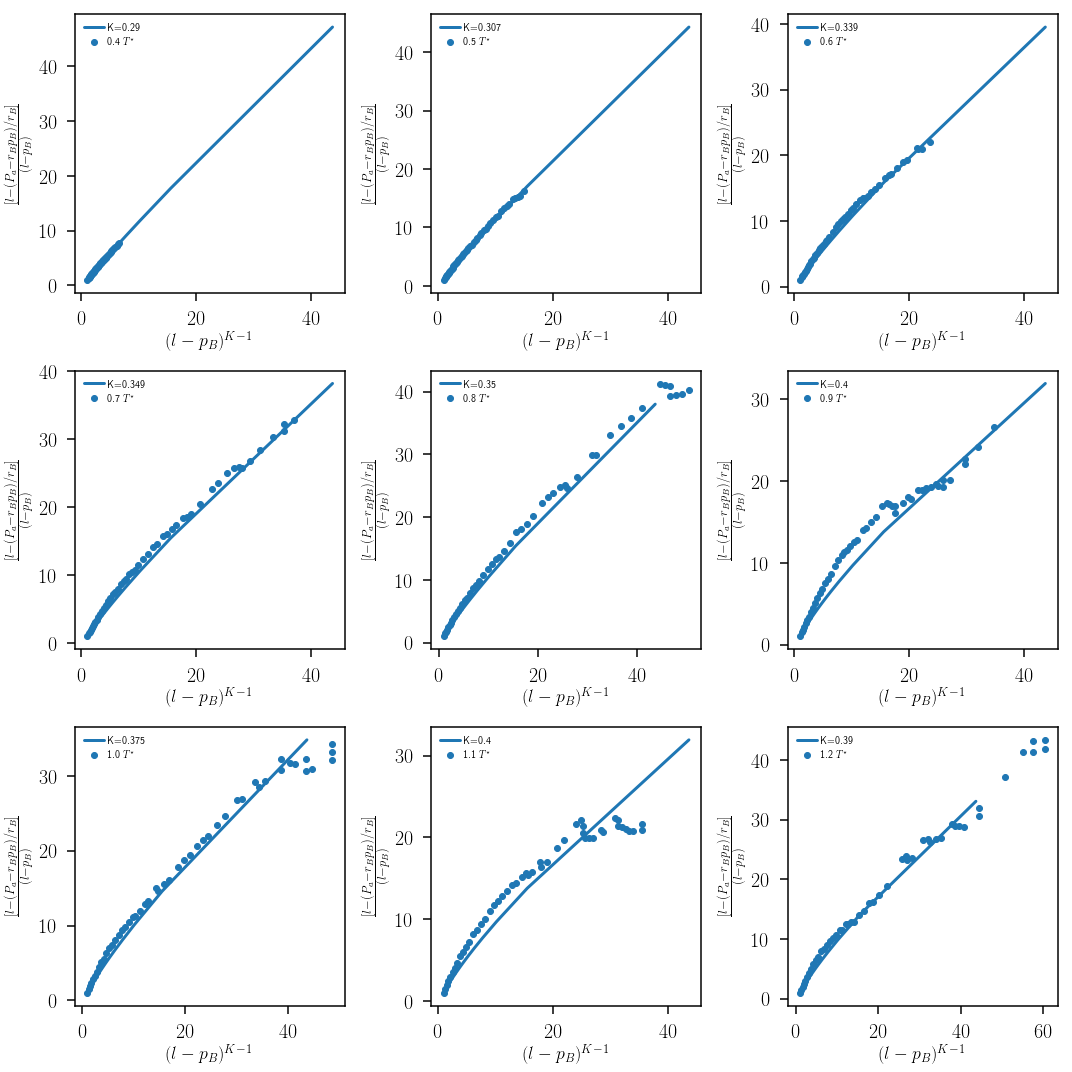

In [481]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
sbws = [2.167]
fig = plt.figure(figsize=(15,15))
pltId = 331
#fig, ax1 = plt.subplots(figsize=(7,10))
kTs=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
#Ks = np.linspace(0.31,0.35,4)  
Ks= [0.29, 0.307, 0.339,0.349,0.350,0.40,0.375,0.40,0.39]
#K=0.349
for K,kT in zip(Ks,kTs):
    plt.subplot(pltId)
    pltId+=1
    #for sbw in sbws:
        #for kT in kTs:
    jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job.sp.temp_prof[-1][1])
        if job.sp.temp_prof[-1][1] ==kT:
            if job_status == 'job-computed':
                #print(job)
                curing_data = np.genfromtxt(job.fn('bond_rank_hist.log'))
                #ax1 = fig.add_subplot(pltId)
                time_steps = curing_data[:,0]/0.01
                cure_percent = curing_data[:,1]
                epoxy_conversion = (100.0-curing_data[:,6])/100.
                primary_amine_conversion = (curing_data[:,2]+curing_data[:,3]+curing_data[:,4]+curing_data[:,5])/100.
                #print(curing_data.shape)
                ones = np.ones_like(epoxy_conversion)
                rbs = ones*0.5
                y = (ones-((epoxy_conversion-(rbs*primary_amine_conversion))/(rbs)))/(ones-primary_amine_conversion)
                x = (ones-primary_amine_conversion)**(K-1)
                plt.scatter(x,y,label='{} $T^\star$'.format(kT))
            else:
                print(job)

        #print(kT,cure_percent)

    pbs = np.linspace(0,0.9929599,endpoint=True)
    #print(pbs)
    pas = pa(pbs,rb=1/2.)
    ones = np.ones_like(pbs)
    rbs = ones*0.5
    pas = pa_k_not_1(pbs,rb=1/2.,k=K)
    y1 = (ones-((pas-(rbs*pbs))/(rbs)))/(ones-pbs)
    x1 = (ones-pbs)**(0.238-1)
    plt.plot(x1,y1,label='K={}'.format(K))                 
    #fig.tight_layout()
    plt.legend()
    #plt.savefig('inside_exponent.png'.format(sbw,kT))
    plt.ylabel(r'$\frac{[l - (P_a - r_Bp_B)/r_B]}{(l - p_B)}$',fontsize=18)
    plt.xlabel(r'$(l - p_B)^{K-1}$',fontsize=18)
    #plt.axis((0.0,1.0,0.0,1.0))
                    
plt.show()

(0.0015683486334455575, 0.0054020897374235871, -2.0, -0.8915392075583527)

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


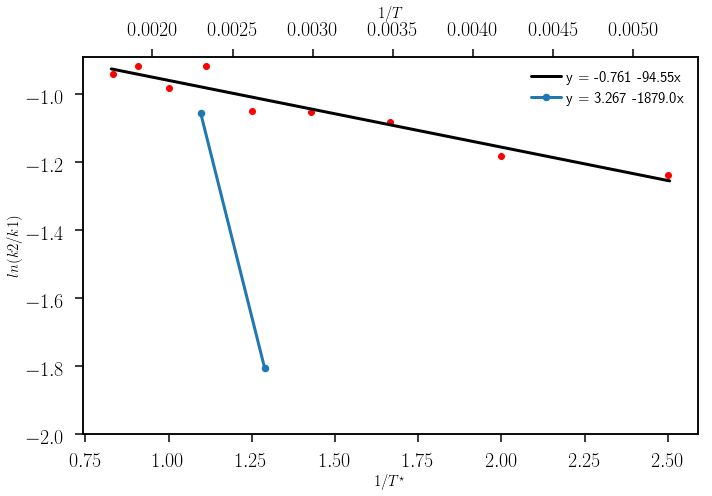

In [474]:
kT=[0.4, 0.5, 0.6,0.8,1.0,1.2]
K = [0.29, 0.307, 0.329,0.339,0.369,0.389]
kT=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
#Ks = np.linspace(0.31,0.35,4)  
K= [0.29, 0.307, 0.339,0.349,0.350,0.40,0.375,0.40,0.39]
kTs = []
Ks = []
kT_star = np.asarray(kT)
kT = np.asarray(kT)*478.21 #conversion from T* to T

kTs = 1/kT
kT_stars = 1/kT_star

for k in K:
    Ks.append(math.log(k))

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111) 
ax2 = ax1.twiny()

ax1.set_xlabel('$1/T^\star$',fontsize=15)
ax1.set_ylabel('$ln(k2/k1)$',fontsize=15)
z = np.polyfit(kT_stars, Ks, deg=1,full=True)
p = np.poly1d(z[0])
df = p(kT_stars)
#print(df)
#print(z)
slope = z[0][0]
intercept = z[0][1]

#ax1.plot(kT_stars,df,color='black',label='y = {}x {}'.format(round(slope,3),round(intercept,3)))
#ax1.legend(fontsize=15)
ax1.scatter(kT_stars,Ks,color='r')
x1,x2,y1,y2 = ax1.axis()
ax1.axis((x1,x2,y1,y2))

z = np.polyfit(kTs, Ks, deg=1,full=True)
p = np.poly1d(z[0])
df = p(kTs)
#print(df)
#print(z)
slope = z[0][0]
intercept = z[0][1]
ax2.set_xlabel('$1/T$',fontsize=15)
ax2.plot(kTs,df,color='black',label='y = {} {}x '.format(round(intercept,3),round(slope,3)))
x1,x2,y1,y2 = ax2.axis()
ax2.axis((x1,x2,y1,y2))


ax2.plot([0.0023,0.0027],[-1.0543,-1.8059],marker='o',label='y =  3.267 -1879.0x')

ax2.legend(fontsize=15,loc="upper right")
x1,x2,y1,y2 = ax2.axis()
ax2.axis((x1,x2,-2.,y2))
#x = [0,1,2]
#y=[]
#for i in x:
#    y.append(slope*i+intercept)
    
#plt.plot(x,y)

ca284264cf0205bf7d76af0a1a756e9a
(50, 7)
be5ec8c95f34e1cbdc8e99c2e2d23044
(50, 7)
3a535908dc785d316d860d912643059a
(50, 7)
d9f27822eb9cda34e96762859617f8f5
(50, 7)
1.2 [  0.      11.315   18.23    24.3775  30.06    35.29    40.2125  44.48
  48.5625  52.2025  55.3625  58.3325  61.0775  63.4175  65.5     67.6
  69.3925  71.055   72.59    73.9475  75.235   76.405   77.4825  78.555
  79.4725  80.3625  81.185   81.96    82.6925  83.29    83.94    84.4875
  85.0175  85.5075  86.005   86.445   86.845   87.27    87.64    87.9675
  88.2875  88.615   88.9125  89.2     89.49    89.72    89.995   90.2375
  90.4675  90.7025]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


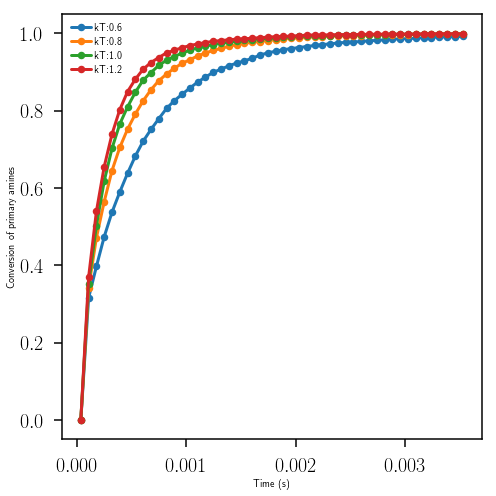

In [478]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('MyProject', data_path)


sbws = [2.167]
fig = plt.figure(figsize=(7,7))
pltId = 221
#fig, ax1 = plt.subplots(figsize=(15,10))
kTs=[0.6,0.8,1.0,1.2]#[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
    
for sbw in sbws:
    for kT in kTs:
        jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
        for job in jobs:
            #print(job)
            job_status = get_status(job)
            #print(job.sp.temp_prof[-1][1])
            if job.sp.temp_prof[-1][1] ==kT:
                if job_status == 'job-computed':
                    print(job)
                    curing_data = np.genfromtxt(job.fn('bond_rank_hist.log'))
                    #ax1 = fig.add_subplot(pltId)
                    time_steps = (curing_data[:,0]/0.01)*7.12e-12
                    cure_percent = curing_data[:,1]
                    epoxy_conversion = (100.0-curing_data[:,6])/100.
                    primary_amine_conversion = (curing_data[:,2]+curing_data[:,3]+curing_data[:,4]+curing_data[:,5])/100.
                    print(curing_data.shape)
                    #ax1.plot(time_steps, cure_percent,linestyle='-',marker='o',label='Cure percent')
                    #ax1.plot(time_steps, epoxy_conversion,linestyle='-',marker='o',label='Conversion of epoxide')
                    #ax1.plot(time_steps, primary_amine_conversion,linestyle='-',marker='o',label='Conversion of primary amine')
                    plt.plot(time_steps, primary_amine_conversion,linestyle='-',marker='o',label='kT:{}'.format(kT))
                    
                    
                    pltId+=1
                else:
                    print(job)
    
    print(kT,cure_percent)

pbs = np.linspace(0,1,endpoint=False)
pas = pa(pbs,rb=1/2.)
#plt.plot(pas,pbs,label='K=1')
pas = pa_k_not_1(pbs,rb=1/2.,k=1/10)
#plt.plot(pas,pbs,linestyle='--',label='K=1/10')                    
fig.tight_layout()
plt.legend()
#plt.savefig('inside_exponent.png'.format(sbw,kT))
plt.xlabel('Time (s)')
plt.ylabel('Conversion of primary amines')
#plt.axis((0.0,1.0,0.0,1.0))
                    
plt.show()